In [1]:
# Libraries:
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

import pysindy as ps

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..'))) # include parent directory in the path
from data import SINDy_data
from data import data
from data import equations

sys.path.append("/home/mattg/D_CODE") # A questo punto è necessario per non doverlo chiamare i file che usano D_CODE.
from toolbox.auxiliary_functions import set_param_freq

# Seed:
np.random.seed(999)

/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


#### Case $k$ varying and $n$, $k_a$, $k_y$ fixed
Consider the modified Van der Pol system with a nonlinear forcing term
$$
\begin{cases}
\dot{x} = \frac{k y^n}{k_a + y^n} \\
\dot{y} = - k_y y
\end{cases}
$$
and with $n=2.8$, $k_a=4$ and $k_y=0.1$ fixed, and $k \in [1,2]$

In [2]:
# Select ODE & settings:
ode_name = 'HillODE_par_k' # help="name of the ode", type=str
ode_param = '2.8,4,0.1' # help="parameters of the ode (default: None)", type=str, default=None
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_ratio = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 100 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10

ode_param, freq = set_param_freq(ode_param, freq)

ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 2
dim_k = 1
time_vector = np.arange(0, ode.T + dt, dt)
T = ode.T

In [3]:
# # Generate data:
# X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_ratio, dim_x, dim_k)
# print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
# print(feature_names)

# # Save data:
# file_path = 'saved/data/hillODE_par_k_data.pkl'
# os.makedirs(os.path.dirname(file_path), exist_ok=True)
# with open(file_path, 'wb') as f:
#     dill.dump((X_list, dX_list, param_list, feature_names), f)

In [4]:
# Uploda data:
file_path = 'saved/data/hillODE_par_k_data.pkl'
with open(file_path, 'rb') as f:
    X_list, dX_list, param_list, feature_names = dill.load(f)

print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

(50, 150, 2) (50, 150, 2) (50, 150)
['X0', 'X1', 'X2']


Threshold:  0.01 , RMSE:  0.23767432829785073
Threshold:  0.02 , RMSE:  0.21934002307183748
Threshold:  0.03 , RMSE:  0.26470905304742487
Threshold:  0.05 , RMSE:  0.8188153130989407
Threshold:  0.08 , RMSE:  0.8188153130989407


/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


Threshold:  0.1 , RMSE:  3.1857724730891435


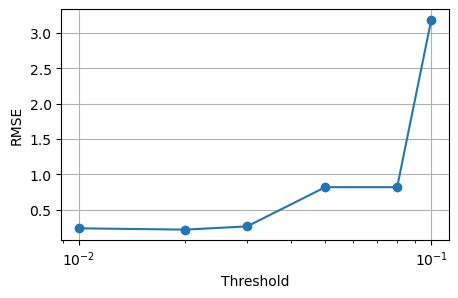

In [5]:
# Model selection:
thresholds = np.array([0.01, 0.02, 0.03, 0.05, 0.08, 0.1])
rmse_values = np.zeros(len(thresholds))
for i in range(len(thresholds)):
    model = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=True), optimizer=ps.STLSQ(threshold=thresholds[i]))
    model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list, u=param_list)
    rmse, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, [10., 10., 2.], [0., 0., 1.], dim_k)
    rmse_values[i] = rmse
    print('Threshold: ', thresholds[i], ', RMSE: ', rmse)  

plt.figure(figsize=(5, 3))
plt.plot(thresholds, rmse_values, marker='o')
plt.xlabel('Threshold')
plt.ylabel('RMSE')
plt.xscale('log')
plt.grid(True)
plt.show()

In [5]:
# Best model fit
model = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(degree=3, include_bias=True), optimizer=ps.STLSQ(threshold=0.02))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list, u=param_list)
print("Estimated SINDy model: ")
model.print()

Estimated SINDy model: 
(X0)' = 0.026 X1 + -0.111 X2 + 0.357 X1 X2 + 0.040 X2^2 + -0.032 X1^2 X2
(X1)' = -0.100 X1


##### Plot per report

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate_traj(model, ode, freq, n_sample, init_high, init_low,
                  dim_x=1, dim_k=1, title=None, T_aux=100):

    np.random.seed(666)
    dt = 1 / freq
    time_vector = np.arange(0, T_aux, dt)
    t = np.arange(0, T_aux, dt)
    T_plot = len(t)

    # true trajectories:
    dg_true = data.DataGenerator(ode, T_aux, freq, n_sample,
                                 noise_sigma=0., init_high=init_high, init_low=init_low)
    xt_true = dg_true.xt

    # estimated trajectories:
    pred_0_list = []
    for i in range(n_sample):
        correct_param = xt_true[0, i, -dim_k:]
        t = np.arange(0, T_aux, dt)
        T_plot = len(t)
        test_params = np.tile(correct_param, (T_plot, 1))
        if dim_k != 0:
            pred_0 = model.simulate(xt_true[0, i, :][:-dim_k], t=t[:T_plot], u=test_params)
        else:
            pred_0 = model.simulate(xt_true[0, i, :], t=t[:T_plot])
        pred_0_list.append(pred_0)

    # reshape
    xt_true = xt_true[:len(pred_0), :, :]
    time_vector = time_vector[:len(pred_0)]
    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]
    xt_true = xt_true.squeeze()
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2)).squeeze()

    # ------------ PLOTTING ------------
    if n_sample == 1:

        # -------- dim_x = 1 ----------
        if dim_x == 1:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            ax.plot(time_vector, pred_0_list, color='blue', linewidth=1.0,
                    alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(time_vector, xt_true, color='red', linewidth=1.0,
                    linestyle='--', label=r'Correct Trajectory')
            ax.scatter(time_vector[0], xt_true[0], color='green', label=r'Start')
            ax.scatter(time_vector[-1], xt_true[-1], color='red', label=r'End')
            ax.set_xlabel(r'$t$')
            ax.set_ylabel(r'$x$')
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='lower right')
            ax.grid(True)

        # -------- dim_x = 2 (RISCRITTO) ----------
        elif dim_x == 2:

            fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

            # ----- PLOT x(t) -----
            axes[0].plot(time_vector, pred_0_list[:, 0], color='blue',
                        linewidth=1.0, alpha=0.7, label=r'Estimated $x(t)$')
            axes[0].plot(time_vector, xt_true[:, 0], color='red',
                        linewidth=1.0, linestyle='--', label=r'Correct $x(t)$')

            # Start & End sulla traiettoria vera
            axes[0].scatter(time_vector[0], xt_true[0, 0], color='green', label='Start')
            axes[0].scatter(time_vector[-1], xt_true[-1, 0], color='red', label='End')

            axes[0].set_ylabel(r'$x(t)$')
            axes[0].legend(fontsize=9)
            axes[0].grid(True)

            # ----- PLOT y(t) -----
            axes[1].plot(time_vector, pred_0_list[:, 1], color='blue',
                        linewidth=1.0, alpha=0.7, label=r'Estimated $y(t)$')
            axes[1].plot(time_vector, xt_true[:, 1], color='red',
                        linewidth=1.0, linestyle='--', label=r'Correct $y(t)$')

            # Start & End sulla traiettoria vera
            axes[1].scatter(time_vector[0], xt_true[0, 1], color='green', label='Start')
            axes[1].scatter(time_vector[-1], xt_true[-1, 1], color='red', label='End')

            axes[1].set_xlabel(r'$t$')
            axes[1].set_ylabel(r'$y(t)$')
            axes[1].legend(fontsize=9)
            axes[1].grid(True)

            if title:
                fig.suptitle(r'%s' % title)

            fig.tight_layout()


        # -------- dim_x = 3 ----------
        else:
            fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': '3d'})
            ax.plot(pred_0_list[:, 0], pred_0_list[:, 1], pred_0_list[:, 2],
                    color='blue', linewidth=1.0, alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(xt_true[:, 0], xt_true[:, 1], xt_true[:, 2],
                    color='red', linewidth=1.0, linestyle='--', label=r'Correct Trajectory')
            ax.scatter(xt_true[:, 0][0], xt_true[:, 1][0], xt_true[:, 2][0], color='green', label=r'Start')
            ax.scatter(xt_true[:, 0][-1], xt_true[:, 1][-1], xt_true[:, 2][-1], color='red', label=r'End')
            ax.set_xlabel(r'$x$')
            ax.set_ylabel(r'$y$')
            ax.set_zlabel(r'$z$')
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='lower right')
            ax.grid(True)


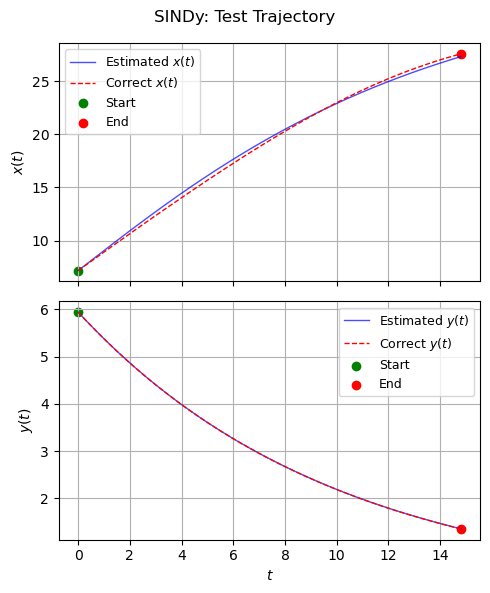

In [7]:
# n_test = 10
# rmse, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_test, [10., 10., 2.], [0., 0., 1.], dim_k)
# print('SINDy Model RMSE: ', rmse)

evaluate_sample = 1
ics = [7., 6., 1.8]
title = 'SINDy: Test Trajectory'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=15)

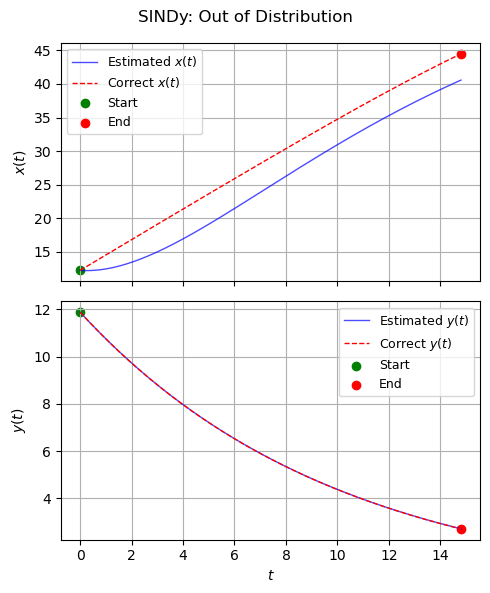

In [16]:
evaluate_sample = 1
ics = [12, 12, 2.3]
title = 'SINDy: Out of Distribution'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=15)

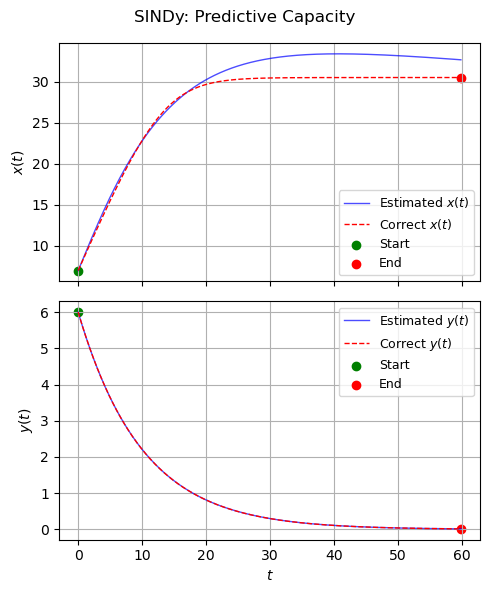

In [13]:
evaluate_sample = 1
ics = [7, 6, 1.8]
title = 'SINDy: Predictive Capacity'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=60)